In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt

import numpy as np

from __future__ import division, print_function

from glob import glob

In [2]:
import time
import lal
from pycbc import frame
from pycbc.filter import resample_to_delta_t

import gw_reconstruct as gwr

/Users/bfarr/Virtualenvs/pycbc/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
ifos = ['H1', 'L1']

cache = '/Users/bfarr/LSC/ER8/G184098/{}.cache'
channel = '{}:DCS-CALIB_STRAIN_C01'

trigtime = 1126259462.3884
bw_deltat = trigtime - 1126259462.39

srate = 1024.
seglen = 4.
time_end = trigtime + 2
time_start = time_end - seglen

data = []
for ifo in ifos:
    ifo_data = resample_to_delta_t(frame.read_frame(cache.format(ifo), channel.format(ifo), time_start, time_end), 1.0/srate)
    data.append(gwr.Strain(ifo_data))
    
times = np.arange(time_start, time_end, 1/srate)
freqs = np.fft.rfftfreq(len(times), 1/srate)

In [4]:
infiles = ['/Users/bfarr/LSC/ER8/G184098/figure/posterior_data/H1_lalinference_psd.dat',
           '/Users/bfarr/LSC/ER8/G184098/figure/posterior_data/L1_lalinference_psd.dat']

psd_flow, psd_fhigh = 16., None

psds = [gwr.psd.interp_from_txt(infile, flow=psd_flow, fhigh=psd_fhigh) for infile in infiles]

In [5]:
post = gwr.posterior.extract_samples('/Users/bfarr/Documents/Research/Publications/cbc/searches/O1/papers/GW150914/parameter_estimation/samples/allIsp_post.dat')

In [6]:
np.random.seed(1234)

nwaves = 199

modeled_strains = []
modeled_whitened_strains = []
for samp in post[np.random.choice(len(post), nwaves, replace=False)]:
    strains = gwr.generate_strain_from_sample(samp, sample_rate=srate, duration=seglen, epoch=time_start, flow=20.)
    white_strains = [gwr.whiten_strain(ht, psd) for ht, psd in zip(strains, psds)]
    modeled_strains.append(strains)
    modeled_whitened_strains.append(white_strains)
    
modeled_ht = gwr.pack_waves(modeled_strains)
whitened_modeled_ht = gwr.pack_waves(modeled_whitened_strains)

In [7]:
wave_infiles = glob('/Users/bfarr/LSC/ER8/G184098/official/bayeswave/signal_wave_10*.0')
bw_times, bw_wtd = np.loadtxt(wave_infiles[0], unpack=True)
bw_times += trigtime - bw_deltat

bw_srate = 4096.
norm = np.sqrt(bw_srate/srate)

wave_low, wave_high = 200, 399

unmodeled_strains = []
unmodeled_whitened_strains = []
for wave in np.random.choice(range(wave_low, wave_high), nwaves, replace=False):
    strains = []
    white_strains = []
    for i, ifo in enumerate(ifos):
        infile = '/Users/bfarr/LSC/ER8/G184098/official/bayeswave/signal_wave_{}.dat.{}'.format(wave, gwr.BW_IFOS[ifo])
        _, white_ht = np.loadtxt(infile, unpack=True)
        
        # Renormalized to this sampling rate
        white_ht *= norm
        
        # Interpolate to achieve requested sampling rate
        bw_interp = gwr.BoundedInterp1D(bw_times, white_ht/np.sqrt(8), outside_domain_val=0.)
        hf = gwr.Strain(bw_interp(times), delta_t=1/srate, epoch=time_start, white=True)
        white_strains.append(hf.copy())
        
        # Recolor the waveforms
        hf.unwhiten(psds[i])
        strains.append(hf)
        
    unmodeled_strains.append(strains)
    unmodeled_whitened_strains.append(white_strains)
unmodeled_ht = gwr.pack_waves(unmodeled_strains)
whitened_unmodeled_ht = gwr.pack_waves(unmodeled_whitened_strains)

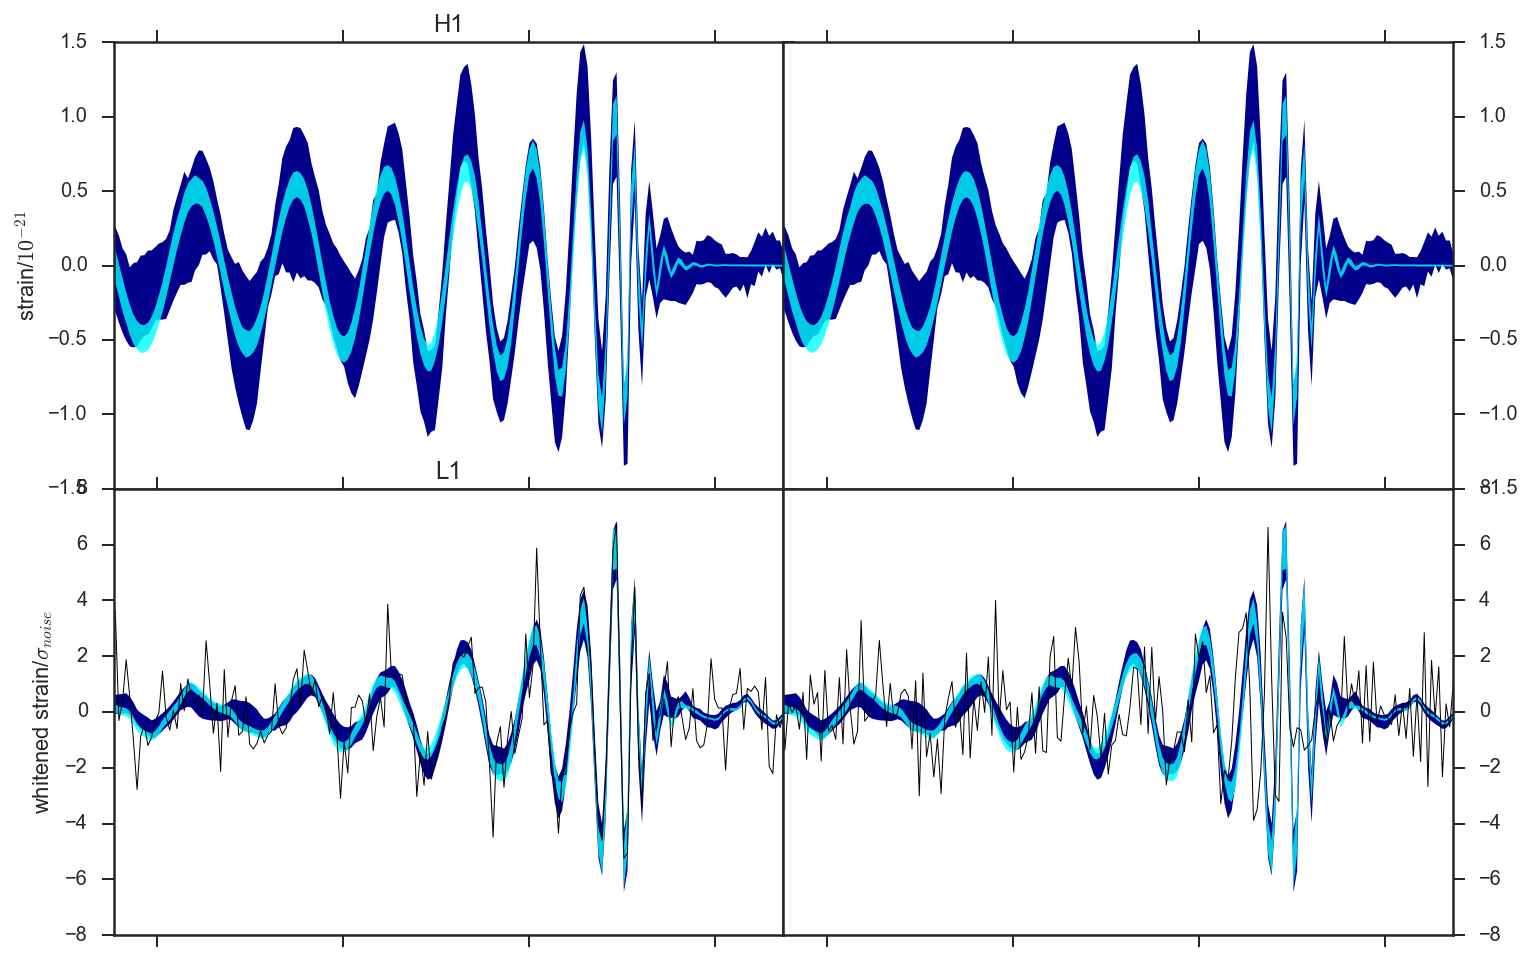

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

for i, ifo in enumerate(ifos):
    # Unwhitened reconstructions
    low, high = gwr.posterior.credible_bounds(unmodeled_ht[0, ...], cl=0.9)
    axs[0][i].fill_between(times, 1e21*low, 1e21*high, lw=0., color='darkblue')

    low, high = gwr.posterior.credible_bounds(modeled_ht[0, ...], cl=0.9)
    axs[0][i].fill_between(times, 1e21*low, 1e21*high, lw=0., color='cyan', alpha=0.8)

    # Whitened reconstructions
    low, high = gwr.posterior.credible_bounds(whitened_unmodeled_ht[0, ...], cl=0.9)
    axs[1][i].fill_between(times, low, high, lw=0., color='darkblue')   

    low, high = gwr.posterior.credible_bounds(whitened_modeled_ht[0, ...], cl=0.9)
    axs[1][i].fill_between(times, low, high, lw=0., color='cyan', alpha=.8)
    
    # Plot whitened data
    axs[1][i].plot(times, gwr.whiten_strain(data[i], psds[i]).tseries, color='k', lw=0.5)

for ax, label in zip(axs, ['strain/$10^{-21}$', 'whitened strain/$\sigma_{noise}$']):
    ax[0].set_ylabel(label)
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_offset_position('right')
    
for ifo, ax in zip(ifos, axs):
    ax[0].set_xlim(trigtime - .1, trigtime + .08)
    ax[0].set_xticklabels([])
    ax[0].set_title(ifo)
    
fig.subplots_adjust(hspace=0., wspace=0.)